## Imports and constants

In [1]:
from fastai.vision import *

In [3]:
classes = ( 'akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc' )

In [4]:
skin_path = Path('data/skin')
dataset_path = Path(skin_path/'HAM_dataset')

In [5]:
dataset_path.ls()

[PosixPath('data/skin/HAM_dataset/hmnist_28_28_L.csv'),
 PosixPath('data/skin/HAM_dataset/HAM10000_images_part_1.zip'),
 PosixPath('data/skin/HAM_dataset/hmnist_8_8_RGB.csv'),
 PosixPath('data/skin/HAM_dataset/HAM10000_metadata.csv'),
 PosixPath('data/skin/HAM_dataset/hmnist_28_28_RGB.csv'),
 PosixPath('data/skin/HAM_dataset/HAM10000_images_part_2.zip'),
 PosixPath('data/skin/HAM_dataset/images'),
 PosixPath('data/skin/HAM_dataset/hmnist_8_8_L.csv')]

In [7]:
# Move kaggle token to good location
import shutil
shutil.move( path/'kaggle.json', '/home/jupyter/.kaggle/kaggle.json' )

'/home/jupyter/.kaggle/kaggle.json'

In [2]:
import json

In [ ]:
with open('/home/jupyter/.kaggle/kaggle.json', 'w') as file:
    json.dump


## Dataset: download and extraction

### Directory creation

In [24]:
dest = path/'HAM_dataset'
dest.mkdir(parents=True, exist_ok=True)
path.ls()

[PosixPath('data/skin/HAM10k'),
 PosixPath('data/skin/.ipynb_checkpoints'),
 PosixPath('data/skin/skin'),
 PosixPath('data/skin/HAMmeta.csv'),
 PosixPath('data/skin/skin-cancer-mnist-ham10000.zip'),
 PosixPath('data/skin/models'),
 PosixPath('data/skin/HAM10000_img1.zip'),
 PosixPath('data/skin/labels.csv'),
 PosixPath('data/skin/HAM_dataset')]

### Download dataset from Kaggle

In [15]:
# Import Kaggle API for python
from kaggle.api.kaggle_api_extended import KaggleApi

In [16]:
# Create Kaggle Api object
api = KaggleApi()

In [17]:
# Anthentifiate with kagggle tokken
api.authenticate()

In [23]:
# Use terminal 'kaggle datasets list -s skin' to find the good reference
# Then download dataset files
api.dataset_download_files('kmader/skin-cancer-mnist-ham10000', path= skin_path)

### Unzipping

In [26]:
path_zip = path/'skin-cancer-mnist-ham10000.zip'
dest = path/'HAM_dataset'
print(path_zip)
print(dest)

data/skin/skin-cancer-mnist-ham10000.zip
data/skin/HAM_dataset


In [27]:
import zipfile
zip_ref = zipfile.ZipFile(path_zip, 'r')
zip_ref.extractall(dest)
zip_ref.close()

In [31]:
zips_path = (dataset_path/'HAM10000_images_part_1.zip', dataset_path/'HAM10000_images_part_2.zip')
zip_dest = dataset_path/'images'
for path in zips_path:
    zip_ref = zipfile.ZipFile(path, 'r')
    zip_ref.extractall(zip_dest)
    zip_ref.close()

DONE

## Build label.csv from metadata provided

In [36]:
import csv

In [37]:
import os

In [47]:
img_list = os.listdir(dataset_path/'images') # retrieve all existing image file names

In [41]:
len(img_list)

10015

In [43]:
# Store in list all file nimages and corresponding diagnostic refs
f_names_list = []
diag_list = []
# Retrieve file names and labels in metadata file IF the file exists in directory
with open(skin_path/'HAMmeta.csv') as meta_file:
    csv_reader = csv.reader(meta_file, delimiter=',')
    line_num = 0
    for line in csv_reader:
        if line_num > 0:
            f_names_list.append(line[1]+'.jpg')
            diag_list.append(line[2])
        line_num += 1
print(len(f_names_list)==len(diag_list)==len(img_list))

True


In [44]:
# create new csv
with open(skin_path/'labels.csv', mode='w') as labels_file:
    csv_writer = csv.writer(labels_file, delimiter=',')
    
    for idx in range(len(f_names_list)):
        csv_writer.writerow(['HAM_dataset/images/'+f_names_list[idx], diag_list[idx]])

## Creating Data Bunch

In [47]:
df = pd.read_csv(skin_path/'labels.csv')
df.head()

,HAM_dataset/images/ISIC_0027419.jpg,bkl
0,HAM_dataset/images/ISIC_0025030.jpg,bkl
1,HAM_dataset/images/ISIC_0026769.jpg,bkl
2,HAM_dataset/images/ISIC_0025661.jpg,bkl
3,HAM_dataset/images/ISIC_0031633.jpg,bkl
4,HAM_dataset/images/ISIC_0027850.jpg,bkl


In [8]:
tfms = get_transforms(flip_vert=True)

In [9]:
np.random.seed(42)
datab = ImageDataBunch.from_csv(skin_path, ds_tfms=tfms, size=64)

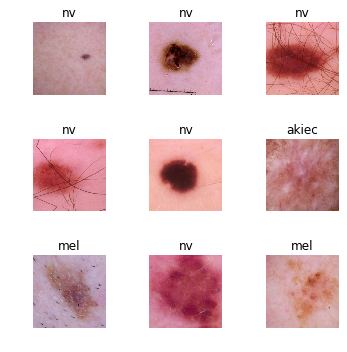

In [12]:
datab.show_batch(rows=3, figsize=(5,5))

In [15]:
print('Classes:',datab.c)
print('Train_set size:', len(datab.train_ds))
print('Valid_set size:', len(datab.valid_ds))

Classes: 7
Train_set size: 8012
Valid_set size: 2002


## Train Resnet34

In [19]:
learner = cnn_learner(datab, models.resnet50, metrics=error_rate)

In [20]:
learner.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.090383,0.684255,0.234266,01:31
1,0.695347,0.562700,0.211289,01:29
2,0.560947,0.502865,0.184815,01:29
3,0.486356,0.482230,0.173327,01:29


In [22]:
learner.save('stage_1')

## Interpret results

In [23]:
interp = ClassificationInterpretation.from_learner(learner)

losses, idxs = interp.top_losses()

len(datab.valid_ds) == len(losses) == len(idxs)

True

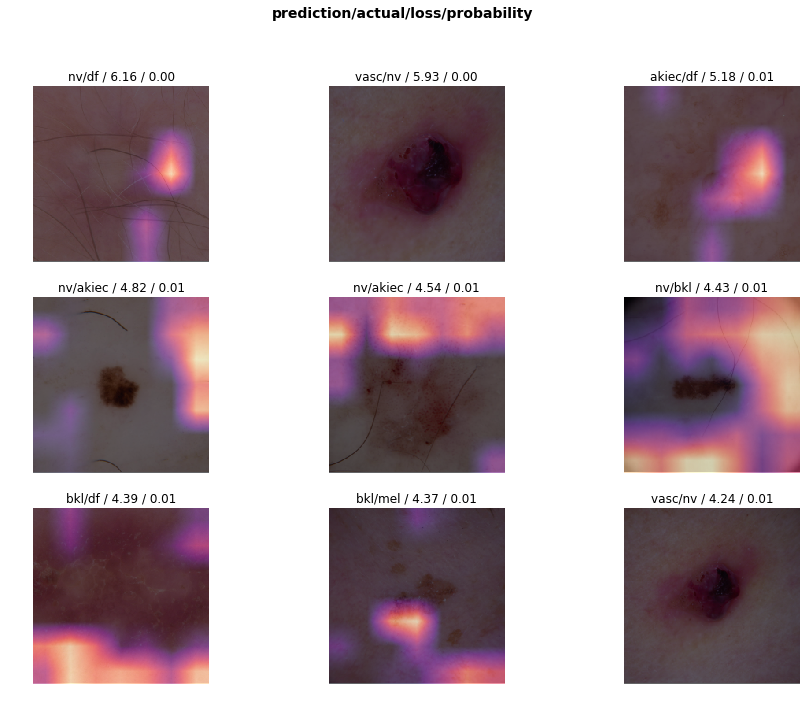

In [27]:
interp.plot_top_losses(9, figsize=(15,11))

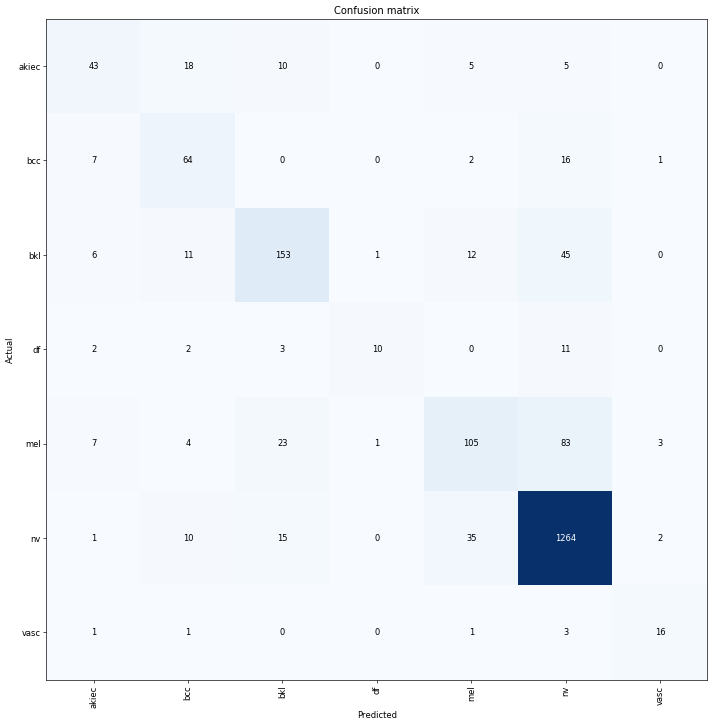

In [28]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=(60))

In [29]:
interp.most_confused(min_val=10)

[('mel', 'nv', 83),
 ('bkl', 'nv', 45),
 ('nv', 'mel', 35),
 ('mel', 'bkl', 23),
 ('akiec', 'bcc', 18),
 ('bcc', 'nv', 16),
 ('nv', 'bkl', 15),
 ('bkl', 'mel', 12),
 ('bkl', 'bcc', 11),
 ('df', 'nv', 11),
 ('akiec', 'bkl', 10),
 ('nv', 'bcc', 10)]

## Unfreezed trainning

In [30]:
learner.unfreeze()

In [31]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


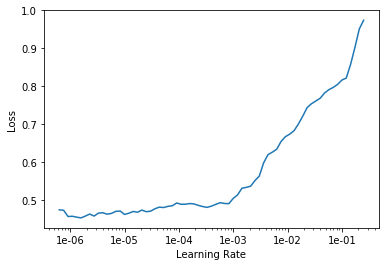

In [32]:
learner.recorder.plot()

In [33]:
learner.load('stage_1')

Learner(data=ImageDataBunch;

Train: LabelList (8012 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
bkl,bkl,bkl,bkl,bkl
Path: data/skin;

Valid: LabelList (2002 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
mel,nv,mel,bkl,nv
Path: data/skin;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 6

In [34]:
learner.unfreeze()
learner.fit_one_cycle(6, max_lr= slice(1e-4, 5e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.584671,0.691115,0.228771,01:52
1,0.602215,0.573984,0.195804,01:54
2,0.557675,0.539299,0.197303,01:53
3,0.455548,0.431025,0.165335,01:54
4,0.335062,0.335187,0.117882,01:54
5,0.250505,0.323531,0.121878,01:53


In [35]:
learner.save('stage-2')

In [36]:
interp = ClassificationInterpretation.from_learner(learner)

losses, idxs = interp.top_losses()

len(datab.valid_ds) == len(losses) == len(idxs)

True

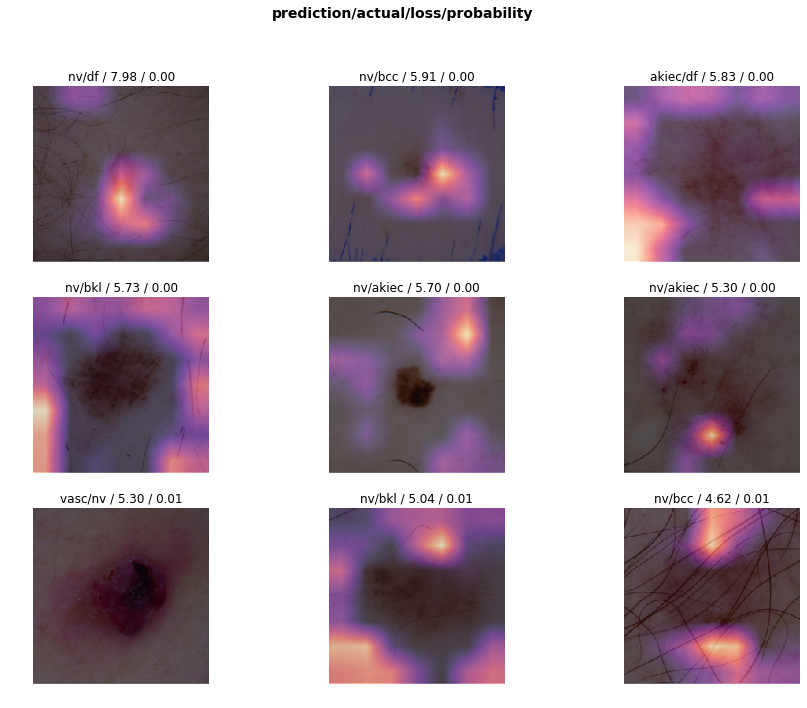

In [37]:
interp.plot_top_losses(9, figsize=(15,11))

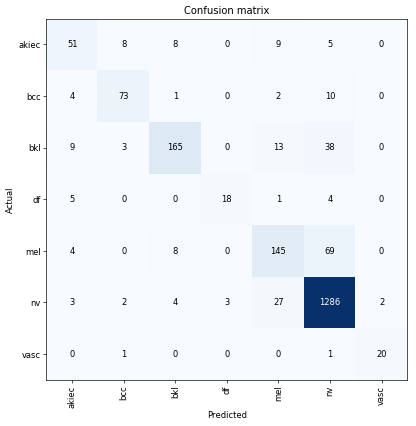

In [40]:
interp.plot_confusion_matrix(figsize=(7,7), dpi=(60))

## Put model in prod

In [43]:
learner.export() # Saves the weights and model trained so far

In [46]:
defaults.device = torch.device('cpu') # Force CPU useage

In [48]:
img_list = os.listdir(dataset_path/'images') # retrieve all existing image file names

In [86]:
import random
img_n = random.choice(img_list)
img_n

'ISIC_0027133.jpg'

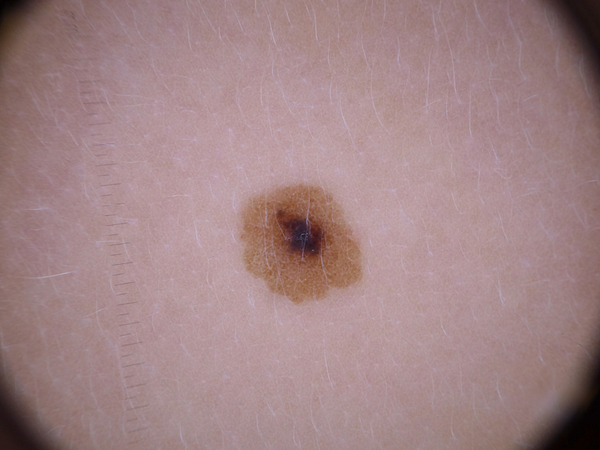

In [87]:
img = open_image(dataset_path/'images'/img_n)
img

In [97]:
learn = load_learner(skin_path)

In [88]:
pred_class, pred_idx, outputs = learn.predict(img)
pred_class

Category nv

In [84]:
def csv_searcher(val):
    """
    Search for specific value in csv file and return first row found
    """
    with open(skin_path/'labels.csv') as f:
        for row in csv.reader(f, delimiter=','):
            if img_n in str(row):
                return row

In [89]:
csv_searcher(img_n)[1]

'nv'

## Test on my spots!

In [96]:
test_path = skin_path/'test_images'
test_path.ls()

[PosixPath('data/skin/test_images/IMG_7258.JPG'),
 PosixPath('data/skin/test_images/IMG_7260.JPG'),
 PosixPath('data/skin/test_images/IMG_7259.JPG')]

In [98]:
for imgn in os.listdir(test_path):
    img = open_image(test_path/imgn)
    print(img)
    pred_class, pred_idx, outputs = learn.predict(img)
    print(pred_class)
    

Image (3, 1447, 1624)
nv
Image (3, 1304, 1381)
nv
Image (3, 1022, 1255)
nv


## Learn more

In [11]:
learner = cnn_learner(datab, models.resnet50, metrics=error_rate).load('stage-2')

In [12]:
learner.freeze()

In [13]:
lr_find(learner)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


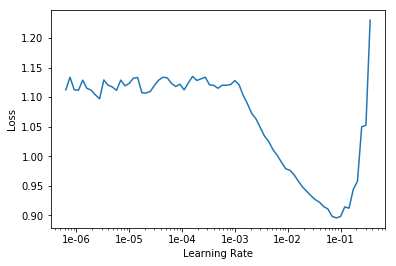

In [14]:
learner.recorder.plot()

In [18]:
lr= 1e-2

In [17]:
learner.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (8012 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
bkl,bkl,bkl,bkl,bkl
Path: data/skin;

Valid: LabelList (2002 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
mel,nv,mel,bkl,nv
Path: data/skin;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3

In [19]:
learner.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.712017,0.632297,0.223277,00:40
1,0.661941,0.546661,0.204296,00:37
2,0.577927,0.527712,0.185814,00:38
3,0.544388,0.499602,0.183317,00:38
4,0.513147,0.496072,0.181818,00:39


In [21]:
learner.save('stage-3')

In [22]:
learner.unfreeze()

In [23]:
lr_find(learner)

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 7.43 GiB total capacity; 646.94 MiB already allocated; 5.94 MiB free; 9.06 MiB cached)